<a href="https://colab.research.google.com/github/Gavin-Moss/Python-for-Math/blob/main/Exploration_2_Newtons_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

The effect of Newton's Method on a linear equation is trivial, so let's start our exporation with its effect on quadratics.

Real line, quadratic:

In [2]:
# A function that takes in the coefficients of a polynomial and an x value, then returns a y value
def poly_point(poly_coeffs, x):
  degree = len(poly_coeffs) - 1
  result = 0
  for i in range(degree + 1):
    result += poly_coeffs[i] * x ** (degree - i)
  return result

# A function that takes in the coefficients of a polynomial and an x value, then returns its derivative at that value
def poly_dev(poly_coeffs, x):
  new_coeffs = np.arange(len(poly_coeffs))[:0:-1] * np.array(poly_coeffs)[:-1]
  return poly_point(new_coeffs, x)

In [3]:
# A function that does Newton's Method
def poly_newton(poly_coeffs, x, precision=10):
  x0, x1 = x, x + 1
  error = 10 ** -(precision + 2)
  c = 0
  while abs(x0 - x1) > error and c != 200:
    x0, x1 = x1, x0 - poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)
    c += 1
  if c == 200:
    return np.pi
  return round(x1, precision)

In [4]:
# A function that takes in n, then returns the RGB values of n "evenly spaced" colors
def evenly_spaced_colors(n):
  colors = np.zeros([n+1, 3], dtype='uint8')
  x_values = np.linspace(0, 1535, n+1, dtype='int')
  for i in range(n+1):
    if x_values[i] in range(0, 256):
      colors[i] = [255, x_values[i], 0]
    elif x_values[i] in range(256, 512):
      colors[i] = [-1-x_values[i], 255, 0]
    elif x_values[i] in range(512, 768):
      colors[i] = [0, 255, x_values[i]]
    elif x_values[i] in range(768, 1024):
      colors[i] = [0, -1-x_values[i], 255]
    elif x_values[i] in range(1024, 1280):
      colors[i] = [x_values[i], 0, 255]
    elif x_values[i] in range(1280, 1536):
      colors[i] = [255, 0, -1-x_values[i]]
  return colors[:-1]

In [ ]:
poly_newton([1, 0, -2], 1.5, 200)

In [ ]:
poly_newtonCount([1, 0, -2], 1.5, 250)

In [ ]:
poly_newton([1,3,-11,12],1000)

In [ ]:
def draw_1D_poly_NM(poly_coeffs, x_int, x_fin, res=500, height=100):
  x_destinations = np.zeros(res)
  x_values = np.linspace(x_int, x_fin, res)
  for i in range(res):
    x_destinations[i] = poly_newton(poly_coeffs, x_values[i], 8)
  bins = []
  for i in range(res):
    if x_destinations[i] not in bins:
      bins.append(x_destinations[i])
  if np.pi in bins:
    colors = evenly_spaced_colors(len(bins) - 1)
    bins.remove(np.pi)
  else:
    colors = evenly_spaced_colors(len(bins))
  print(bins)
  print(colors)
  colors_dict = {}
  for i in range(len(bins)):
    colors_dict[bins[i]] = colors[i]
  print(colors_dict)
  img_arr = np.zeros([height, res, 3], dtype='uint8')
  for i in range(res):
    if x_destinations[i] != np.pi:
      img_arr[:, i] = colors_dict[x_destinations[i]]
  img = Image.fromarray(img_arr)
  display(img)

In [ ]:
draw_1D_poly_NM([-0.3, -0.9, 0.9, 2.5, -2.1, -1.2, 0.5], -3, 2, res=2000, height=300)

NOTES FOR ME:


*  going to try to visualize the rate of converge of newtons method using matplotlib
*  newton's method is an algorithm which estimates the root of polynomials

In [5]:
# A function that counts how many times it iterates
def poly_newtonCount(poly_coeffs, x, precision=10):
  x0, x1 = x, x + 1
  error = 10 ** -(precision + 2)
  c = 0
  while abs(x0 - x1) > error and c != 200:
    x0, x1 = x1, x0 - poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)
    c += 1
  if c == 200:
    return np.pi
  return c

In [6]:
def GraphRateOfConvergence(poly_coeffs, x):
  #lets make a line plot to show rate of convergence?
  #This line plot start at x=0 as our highest point, and then approach 0, as our iterations increase, as our approximation
  #gets closer to the real root

  root = poly_newton([1, 0, -2], 1.5, 100) #this is the root with precision to 100 digits
  #error = abs((SOMETHING) - root) this something should be xn+1 everytime we iterate newtons method, but im not sure how to get that

  iterations = np.arange(0,poly_newtonCount(poly_coeffs,x,1000)) #counts the iterations
#NOTE, either i'm misunderstanding the count or our code is very efficient, cuz it seems like it always iterates 10 times 
#in this example, even with really high precision

  test = np.linspace(0,poly_newton(poly_coeffs,x),10) #???

  plt.figure()
  plt.plot(iterations, test, alpha = 0.5, c = 'blue')
  plt.title('Rate Of Convergence of Newtons Method')
  plt.xlabel('Iterations')
  plt.ylabel('Error') #as of right now, the y axis is definitely not the error.

In [ ]:
GraphRateOfConvergence([1, 0, -2], 1.5)

Wednesday Night: \\
Right now the problem is that I need to get the values xn+1 (the new approximation after each iteration) so that I can find the error after each iteration then graph it.  \\
I don't see a way to get the value of each iteration, so maybe i can make a new function?

In [8]:
def test_poly_newton(poly_coeffs, x, precision=10):
  x0, x1 = x, x + 1
  error = 10 ** -(precision + 2)
  c = 0
  while abs(x0 - x1) > error and c != 200:
    x0, x1 = x1, x0 - poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)
    print(x0)
    c += 1
  if c == 200:
    return np.pi
  return round(x1, precision)

In [ ]:
test_poly_newton([1,0,-2] ,1.5)

it seems that this prints every value after an iteration, but obvioulsy this just prints, i need a way to call the actual value.
  
I feel like recursion could work ??? but we haven't learned that and i'd be very out of practice.

I'll try a function that does the iteration only once.

In [9]:
def OneIteration(poly_coeffs, x, precision=10):
  if poly_dev(poly_coeffs,x) == 0:
    raise ValueError('Out of Basin')
  x0, x1 = x, x + 1
  error = 10 ** -(precision + 2)

  x0, x1 = x1, x0 - poly_point(poly_coeffs, x0) / poly_dev(poly_coeffs, x0)
  return round(x1, precision)

In [ ]:
OneIteration([1,0,-2] ,1.5)

1.4166666667

In [ ]:
OneIteration([1,0,-2], OneIteration([1,0,-2] , 1.5))

In [ ]:
#I'll try to make a 1D numpy array of each iteration
AllEstimates = np.linspace(1.5,poly_newton([1,0,-2] ,1.5),10 ) #starts at 1.5 cuz thats our first guess
print(AllEstimates)

for i in range(len(AllEstimates)-1):
  AllEstimates[i+1] = OneIteration([1,0,-2], AllEstimates[i]) # this array should be the array of each iteration
  #til we converged to the root
print(AllEstimates)

#now lets try to make it a plot
iterations = np.arange(0,poly_newtonCount([1,0,-2],1.5,1000))
plt.figure()
plt.plot(iterations, AllEstimates, alpha = 0.5, c = 'blue')
plt.title('Rate Of Convergence of Newtons Method')
plt.xlabel('Iterations')
plt.ylabel('Approximation of root')
#well the graph... works! but since our guess is kind of far off it's hard to see anything
#but you can see that the first iteration works very well, then the 2nd optimizes it,
#then after the 2nd, its practically correct.

In [66]:
#The above code has some noticable flaws, but it works. 
#I'll try to create a function that takes actual inputs, since the above code only uses one example.
def GraphRateOfConvergence2(poly_coeffs,x):
  root = poly_newton(poly_coeffs, x, 100) #this is the root with precision to 100 digits
  #error = abs((SOMETHING) - root) this something should be xn+1 everytime we iterate newtons method, but im not sure how to get that

  iterations = np.linspace(0,10,poly_newtonCount(poly_coeffs,x,10)) #counts the iterations

  Approximations = np.linspace(x, root, poly_newtonCount(poly_coeffs,x))
  for i in range(len(Approximations)-1):
    Approximations[i+1] = OneIteration(poly_coeffs, Approximations[i])

  plt.figure()
  plt.plot(iterations, Approximations, alpha = 0.5, c = 'blue')
  plt.title('Rate Of Convergence of Newtons Method')
  plt.xlabel('Iterations')
  plt.ylabel('Approximations')

  Error = Approximations
  for j in range(len(Approximations)):
    Error[j] = abs(root - Approximations[j])
    Approximations[j] = Error[j]
  #plt.plot(iterations,Error)

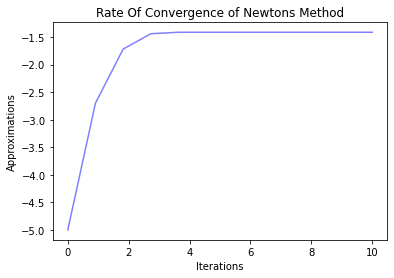

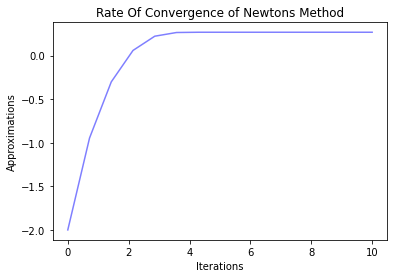

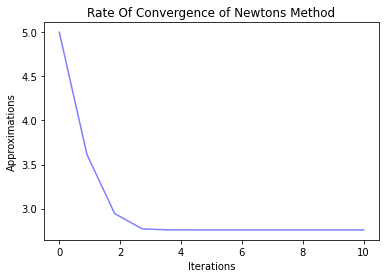

In [67]:
GraphRateOfConvergence2([1,0,-2],-5)
#I have a problem that my array for the iterations is not always the same lengths
#as the arrays for the approximations
#ACTUALLY I THINK I DID IT i changed iterations to be of linspace instead of arange

#this graph shows, with an initial guess of -5, newton's method converging
#to the root of x^2 - 2 = 0 (the root closer to the guess)
#the blue is the error, and the purple are the actual approximations, but they seem to be same graph
#just shifted vertically by the value of the root

GraphRateOfConvergence2([1,-5,5,-1],-2) #error ???

GraphRateOfConvergence2([1,0,0,-21],5) 